<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis 
* iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg 
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 

import os
import re
from functools import reduce
from collections import defaultdict, Counter, ChainMap


# customer analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sample_data']

In [21]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [22]:
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [23]:
df = df[df.order_status == 'Approved']
df.transaction_date = df.transaction_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')
df = df[['customer_id', 'date', 'month', 'list_price']].rename(columns = {'customer_id':'id', 'list_price':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,id,date,month,rev
0,1,2017-01-05,2017-01-01,360.4
1,1,2017-02-21,2017-02-01,71.49
2,1,2017-03-27,2017-03-01,688.63
3,1,2017-03-29,2017-03-01,1274.93
4,1,2017-04-06,2017-04-01,1577.53


In [35]:
df_ = df.assign(
    week = df.groupby(['id'])['date'].apply(
        lambda x : (x - x.dt.weekday.astype('timedelta64[D]')))
    ).assign(
        days = lambda x : (x['date']-x['week']).dt.days
        )
df_.head()

,id,date,month,rev,week,days
0,1,2017-01-05,2017-01-01,360.4,2017-01-02,3
1,1,2017-02-21,2017-02-01,71.49,2017-02-20,1
2,1,2017-03-27,2017-03-01,688.63,2017-03-27,0
3,1,2017-03-29,2017-03-01,1274.93,2017-03-27,2
4,1,2017-04-06,2017-04-01,1577.53,2017-04-03,3


In [36]:
df_ = df_.groupby(['week', 'days'])['rev'].count().reset_index().rename(columns = {'rev':'pu'}).assign()
df_['ratio'] = df_.groupby('week')['pu'].apply(lambda x: round(x/x.max() * 100, 2))
df_.head()

,week,days,pu,ratio
0,2016-12-26,6,51,100.00
1,2017-01-02,0,46,75.41
2,2017-01-02,1,56,91.80
3,2017-01-02,2,58,95.08
4,2017-01-02,3,61,100.00


In [37]:
df_['week'] = df_['week'].astype(str)
df_ = pd.melt(df_, id_vars = ['week','days'], var_name = 'type')

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


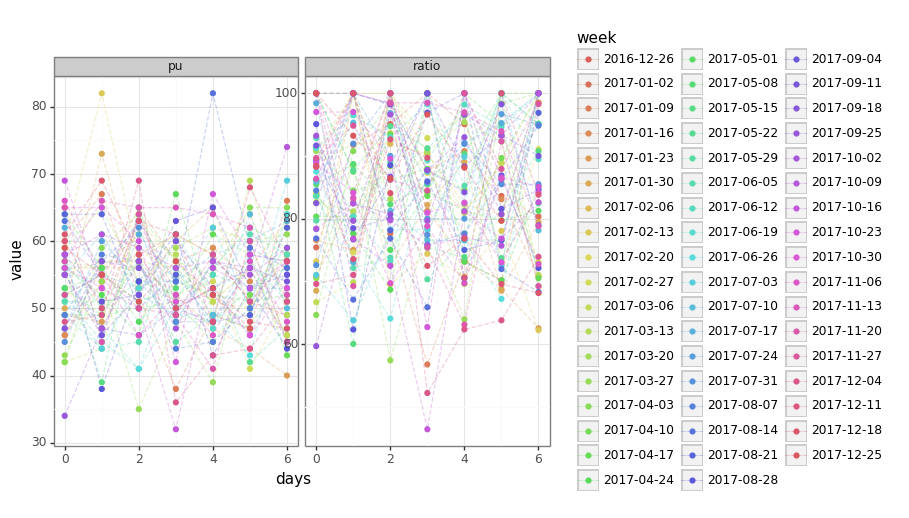

<ggplot: (8736714440245)>

In [38]:
(
    ggplot(df_, aes('days', 'value', color = 'week')) +
    gg.geom_line(alpha = .3, linetype = 'dashed') +
    gg.geom_point() +
    gg.facet_wrap('~type', scales = 'free_y') + 
    gg.theme_bw()
)

# iterator

In [39]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[f'({r}, {c})-{letters}' for c, rows in enumerate(mat) for r, letters in enumerate(rows)]

['(0, 0)-A',
 '(1, 0)-B',
 '(2, 0)-C',
 '(0, 1)-D',
 '(1, 1)-E',
 '(2, 1)-F',
 '(0, 2)-G',
 '(1, 2)-H',
 '(2, 2)-I']

In [40]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [42]:
wow = {key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}
wow

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [57]:
a = defaultdict(list)
for user in users : 
  for k, v in user.items() :
    a[k].append(v)
a

defaultdict(list,
            {'mail': ['gregorythomas@gmail.com',
              'hintoncynthia@hotmail.com',
              'wwagner@gmail.com',
              'daniel79@gmail.com',
              'ujackson@gmail.com'],
             'name': ['Brett Holland',
              'Madison Martinez',
              'Michael Jenkins',
              'Karen Rodriguez',
              'Amber Rhodes'],
             'sex': ['M', 'F', 'M', 'F', 'F'],
             'age': [73, 29, 51, 32, 42]})

In [59]:
ChainMap(a, wow)

ChainMap(defaultdict(<class 'list'>, {'mail': ['gregorythomas@gmail.com', 'hintoncynthia@hotmail.com', 'wwagner@gmail.com', 'daniel79@gmail.com', 'ujackson@gmail.com'], 'name': ['Brett Holland', 'Madison Martinez', 'Michael Jenkins', 'Karen Rodriguez', 'Amber Rhodes'], 'sex': ['M', 'F', 'M', 'F', 'F'], 'age': [73, 29, 51, 32, 42]}), {'mail': ['gregorythomas@gmail.com', 'hintoncynthia@hotmail.com', 'wwagner@gmail.com', 'daniel79@gmail.com', 'ujackson@gmail.com'], 'name': ['Brett Holland', 'Madison Martinez', 'Michael Jenkins', 'Karen Rodriguez', 'Amber Rhodes'], 'sex': ['M', 'F', 'M', 'F', 'F'], 'age': [73, 29, 51, 32, 42]})